In [7]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import SimpleITK as sitk
import os

In [8]:
def register_and_get_image_data_itk(name, routeM, moving, imagen_referencia):
    # Load fixed and moving images
    # route = filedialog.askopenfilename(filetypes=[("Image files", "FLAIR.nii.gz")])
    fixed_image = sitk.ReadImage(routeM)
    moving_image = sitk.ReadImage(moving)
    original_image = sitk.ReadImage(imagen_referencia)
    #moving_image_segmentation = sitk.ReadImage(moving_image_path)

    # Convert image types
    fixed_image = sitk.Cast(fixed_image, sitk.sitkFloat32)
    moving_image = sitk.Cast(moving_image, sitk.sitkFloat32)
    original_image = sitk.Cast(original_image, sitk.sitkFloat32)
    #moving_image_segmentation = sitk.Cast(moving_image_segmentation, sitk.sitkFloat32)

    # Define the registration components
    registration_method = sitk.ImageRegistrationMethod()

    # Similarity metric - Mutual Information
    registration_method.SetMetricAsMattesMutualInformation()

    # Interpolator
    registration_method.SetInterpolator(sitk.sitkNearestNeighbor)

    # Optimizer - Gradient Descent
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100,
                                                     estimateLearningRate=registration_method.EachIteration)

    # Initial transform - Identity
    initial_transform = sitk.Transform()
    registration_method.SetInitialTransform(initial_transform)

    # Setup for the registration process
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Perform registration
    final_transform = registration_method.Execute(fixed_image, original_image)

    # Resample the moving image to match the fixed image dimensions and orientation
    
    registered_image = sitk.Resample(original_image, fixed_image, final_transform, sitk.sitkNearestNeighbor, 0.0, fixed_image.GetPixelID())

    # Convert the resampled image to Numpy array
    #resampled_array = sitk.GetArrayFromImage(resampled_image)
    
    # Save the resampled image as NIfTI
    output_image_path = f'../images/{name}.nii.gz'
    sitk.WriteImage(registered_image, output_image_path)

In [9]:
register_and_get_image_data_itk("FLAIR_T1", routeM='../images/FLAIR.nii.gz', moving='../images/T1.nii.gz', imagen_referencia='../images/T1_seg.nii.gz')
register_and_get_image_data_itk("FLAIR_IR", routeM='../images/FLAIR.nii.gz', moving='../images/IR.nii.gz', imagen_referencia='../images/IR_seg.nii.gz')

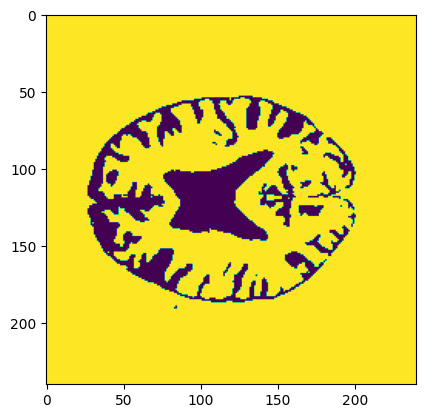

In [10]:
T1 = nib.load('../images/FLAIR_IR.nii.gz').get_fdata()
plt.imshow(T1[:,:,25])

In [20]:
def kMeans (image, iterations,ks ):
	# Inicialización de valores k
	k_values = np.linspace(np.amin(image), np.amax(image), ks)
	for i in range(iterations):
		d_values = [np.abs(k - image) for k in k_values]
		segmentationr = np.argmin(d_values, axis=0)

		for k_idx in range(ks):
			k_values[k_idx] = np.mean(image[segmentationr == k_idx])

	return segmentationr

In [17]:
def remote():
        # Cargar la imagen NIfTI
    nifti_img = nib.load('../images/IR_reg.nii.gz')  # Asegúrate de ajustar la ruta y el nombre del archivo

    # Obtener los datos de la imagen
    data = nifti_img.get_fdata()

    # Preprocesamiento opcional
    # data = cv2.medianBlur(data, 5)  # Ejemplo de suavizado con filtro de mediana

    # Definir escalas espaciales
    scales = [7.5]  # Escalas para aplicar filtros gaussianos

    # Aplicar filtros gaussianos en diferentes escalas
    filtered_images = []
    for scale in scales:
        # Aplicar filtro gaussiano
        filtered = ndimage.gaussian_filter(data, sigma=scale)
        filtered = kMeans(filtered, 10, 2)
        # Crear una nueva imagen nibabel con el cerebro extraído
        brain_extracted_image = nib.Nifti1Image(filtered, affine=nifti_img.affine, dtype=np.int16)

        
        # Guardar la imagen con el cerebro extraído en un nuevo archivo
        nib.save(brain_extracted_image, '../images/IR_skull.nii.gz')
        filtered_images.append(filtered)

    # RESTAR UNA IMAGEN 

    # Cargar las imágenes
    imagen_original = sitk.ReadImage('../images/T1_reg.nii.gz')
    imagen_referencia = sitk.ReadImage('../images/IR_skull.nii.gz')

    # Realizar segmentación basada en umbral adaptativo
    otsu_filter = sitk.OtsuThresholdImageFilter()
    otsu_filter.SetInsideValue(1)
    otsu_filter.SetOutsideValue(0)
    mascara_referencia = otsu_filter.Execute(imagen_referencia)

    # Aplicar la máscara a la imagen original
    imagen_sin_craneo = sitk.Mask(imagen_original, mascara_referencia)

    # Obtener los datos de la imagen sin el cráneo
    # Obtener los datos de la imagen sin el cráneo
    data_sin_craneo = sitk.GetArrayFromImage(imagen_sin_craneo)

    # Obtener los datos de la máscara
    data_mascara = sitk.GetArrayFromImage(mascara_referencia)

    # Crear una máscara booleana para los valores cero dentro del cerebro
    mascara_cero_cerebro = (data_sin_craneo == 0) & (data_mascara != 0)

    # Asignar un valor distinto a los valores cero dentro del cerebro
    valor_distinto = 6
    data_sin_craneo[mascara_cero_cerebro] = valor_distinto

    # Crear una nueva imagen SimpleITK con los datos modificados
    imagen_sin_craneo_modificada = sitk.GetImageFromArray(data_sin_craneo)
    imagen_sin_craneo_modificada.CopyInformation(imagen_sin_craneo)

    # Guardar la imagen sin el cráneo
    sitk.WriteImage(imagen_sin_craneo_modificada, '../images/FLAIR_skull.nii.gz')

In [21]:
remote()

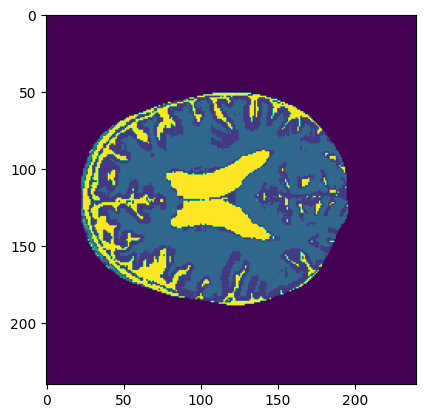

In [23]:
img = nib.load('../images/FLAIR_skull.nii.gz').get_fdata()
plt.imshow(img[:,:,25])